Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)

352×4 DataFrame
│ Row │ height   │ weight   │ age      │ male   │
│     │ Float64⍰ │ Float64⍰ │ Float64⍰ │ Int64⍰ │
├─────┼──────────┼──────────┼──────────┼────────┤
│ 1   │ 151.765  │ 47.8256  │ 63.0     │ 1      │
│ 2   │ 139.7    │ 36.4858  │ 63.0     │ 0      │
│ 3   │ 136.525  │ 31.8648  │ 65.0     │ 0      │
│ 4   │ 156.845  │ 53.0419  │ 41.0     │ 1      │
│ 5   │ 145.415  │ 41.2769  │ 51.0     │ 0      │
│ 6   │ 163.83   │ 62.9926  │ 35.0     │ 1      │
│ 7   │ 149.225  │ 38.2435  │ 32.0     │ 0      │
⋮
│ 345 │ 146.05   │ 39.4058  │ 37.4     │ 0      │
│ 346 │ 156.21   │ 41.0501  │ 53.0     │ 1      │
│ 347 │ 152.4    │ 40.8233  │ 49.0     │ 0      │
│ 348 │ 162.56   │ 47.0318  │ 27.0     │ 0      │
│ 349 │ 142.875  │ 34.2462  │ 31.0     │ 0      │
│ 350 │ 162.56   │ 52.1631  │ 31.0     │ 1      │
│ 351 │ 156.21   │ 54.0625  │ 21.0     │ 0      │
│ 352 │ 158.75   │ 52.5316  │ 68.0     │ 1      │

Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain);
# Input data for cmdstan
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight]);

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/04



Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Show first 5 individual draws of correlated parameter values in chain 1
chn.value[1:5,:,1]


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: weights_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.73, 0.68, 0.64, 0.74) seconds, 2.8 seconds total
Sampling took (0.69, 0.69, 0.70, 0.60) seconds, 2.7 seconds total

                 Mean     MCSE   StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -747  4.4e-02  1.3e+00   -750  -747  -746  8.3e+02  3.1e+02  1.0e+00
accept_stat__    0.93  1.5e-03  1.0e-01   0.71  0.97   1.0  4.4e+03  1.6e+03  1.0e+00
stepsize__      0.099  6.5e-03  9.2e-03  0.090  0.10  0.11  2.0e+00  7.5e-01  5.8e+13
treedepth__       4.0  2.0e-02  1.2e+00    2.0   4.0   5.0  3.6e+03  1.3e+03  1.0e+00
n_leapfrog__     

5×3 Array{Union{Missing, Float64},2}:
 110.29   0.975185  4.98637
 111.941  0.945555  4.91393
 112.084  0.942247  4.9315 
 112.056  0.94217   4.93002
 116.123  0.857742  4.94802

Plot estimates using the N = [10, 50, 150, 352] observations


make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

make: `/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.


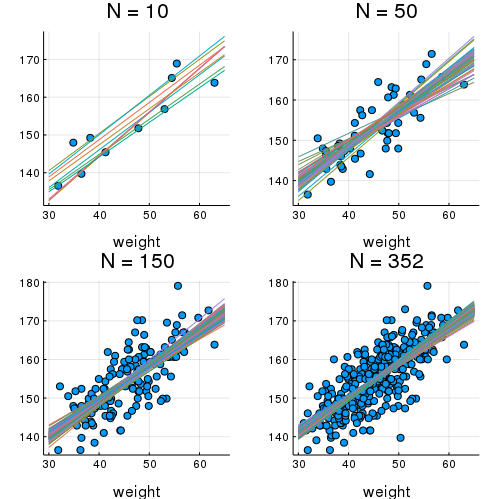

In [8]:
p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
nvals = [10, 50, 150, 352]

for i in 1:length(nvals)
  N = nvals[i]
  heightsdataN = [
    Dict("N" => N, "height" => df2[1:N, :height], "weight" => df2[1:N, :weight])
  ]
  rc, chnN, cnames = stan(stanmodel, heightsdataN, ProjDir, diagnostics=false,
    summary=false, CmdStanDir=CMDSTAN_HOME)

  xi = 30.0:0.1:65.0
  rws, vars, chns = size(chnN[:, 1, :])
  alpha_vals = convert(Vector{Float64}, reshape(chnN.value[:, 1, :], (rws*chns)))
  beta_vals = convert(Vector{Float64}, reshape(chnN.value[:, 2, :], (rws*chns)))

  p[i] = scatter(df2[1:N, :weight], df2[1:N, :height], leg=false, xlab="weight")
  for j in 1:N
    yi = alpha_vals[j] .+ beta_vals[j]*xi
    plot!(p[i], xi, yi, title="N = $N")
  end
end
plot(p..., layout=(2, 2))

End of `clip_45_47s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*